<h1><span style="font-family:Georgia, serif;"><strong><span style="font-size:24px;">Instantons</span></strong>
</span></h1>
<h2>Computing instanton rates using i-PI</h2>

In this exercises we will use i-PI not to run molecular dynamics but instead to optimize stationary points on the potential-energy surface. Then by simple extension, the ring-polymer instanton will be found which can be used to compute the thermal rate of a chemical reaction including tunnelling effects.
The example which we will use is for the gas-phase bimolecular scattering reaction of H + CH_4 . This requires multiple runs of i-PI for the different stationary points on the surface followed by one postprocessing calculation to combine all the data to compute the rate.
Full details of the instanton approach are described in [1].

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cycler
from scipy import constants

plt.rc('text', usetex=True)
plt.rc('ps', usedistiller = 'xpdf')
plt.rcParams['legend.fontsize'] = 'x-large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'
params = {'figure.figsize':(12, 5)}
plt.rcParams['axes.prop_cycle'] = cycler(color=['r','b','k','g','y','c'])

A typical workflow is summarized as follows:

1. Optimize the minimum or minima and perform normal-mode analysis.
2. Optimize the transition state and perform normal-mode analysis.
3. Make an initial guess for an N = 16 configuration.
4. Compute Hessians of each bead. (This can be done approximately.)
5. Optimize N = 16 instanton using eigenvector following, computing gradients at each iteration, and using the Powell update formula on the ring-polymer Hessian.
6. Double number of beads by interpolation of positions and Hessians to give new guess configuration.
7. Optimize with Newton-Raphson, computing gradients at each iteration, and using the Powell update formula on the ring-polymer Hessian.
8. Recompute Hessians for each bead. (This must be done accurately.)
9. Evaluate the fluctuation terms and hence the rate, k .
10. Return to step 7 until the rate converges.

If rates are required at more than one temperature, it is recommended to start with those closest to the crossover temperature and cool sequentially, again using initial guesses from the previous optimizations.

<h2>Exercise 1 - Optimizing and analysing the reactant</h2>

1. Go to the folder `input/reactant/minimization`. A good initial guess has been provided in `init.xyz` and the input file `input.xml`. Look at the input file which should be fairly self explanatory. Note that the text between `<!--` and `-->` is a comment.
Then run i-PI using

    `$ i-pi input.xml &`

    and the driver using
    
    `$ i-pi-driver -m ch4hcbe -u`

	The simulation takes 31 steps and the final geometry can be seen in the last frame in `min.xc.xyz`. Once you finish this exercise, you could come back here and try to get the optimization to finish in fewer steps, e.g. by changing `sd` to one of the other optimizers.

    Note that as this is a bimolecular reaction, the H and the CH4 should be well separated and we have used a very large box size. We have used the CBE potential-energy surface [2].

2. Next, go to the folder `input/reactant/phonons` and copy the optimized geometry just obtained (last 8 lines) into a new file called `init.xyz` . We will now compute the hessian of this minimum. Run 

	`$ i-pi input.xml &`
    
	`$ i-pi-driver -m ch4hcbe -u`
	
    The hessian is saved in `phonons.hess` and its eigenvalues in `phonons.eigval`. Check that it has the required number (9) of almost zero eigenvalues. Why?

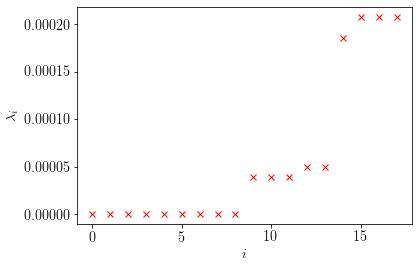

In [15]:
eigvals = np.genfromtxt('input/reactant/phonons/min.phonons.eigval')
plt.plot(eigvals,'x')
plt.xlabel('$i$')
plt.ylabel('$\lambda_i$')
plt.show()

<h2>Exercise 2 - Optimizing and analysing the transition state</h2>

Go to `input/TS` and optimize the transition state using the usual run commands. Here i-PI treats the TS search as a one-bead instanton optimization. The simulation takes 12 steps and puts the optimized geometry in `INSTANTON_FINAL_12.xyz` and its Hessian in `INSTANTON_FINAL.hess_12`. Visualize the geometry using `vmd`.


<h2>Exercise 3 - First instanton optimization </h2>

4. Go to the folder `input/instanton/40`. Copy the optimized transition state geometry obtained in <strong>Exercise 2</strong> and name it `init.xyz`. Also copy the transition state hessian and name it `hessian.dat`. 
Run i-PI in the usual way, but here we can run 4 instances of driver simultaneously using:

	`$ i-pi-driver -m ch4hcbe -u &`
	`$ i-pi-driver -m ch4hcbe -u &`
	`$ i-pi-driver -m ch4hcbe -u &`
	`$ i-pi-driver -m ch4hcbe -u &`
	
	The program first generates the initial instanton guess based on points spread around the TS in the direction of the imaginary mode. It then an optimization which takes 8 steps.
The instanton geometry is saved in `INSTANTON_FINAL_7.xyz` and should be visualized with `vmd`. Finally hessians for each bead are also computed and saved in `INSTANTON_FINAL.hess_7` in the shape (3N,3Nn).

<h2> Exercise 4 - Second and subsequent instanton optimizations</h2>

1. Make the folder `input/instanton/80`.
2. Go to the folder `input/instanton/80`.
3. Copy the optimized transition state geometry obtained in <strong>Exercise 2</strong> and name it `init.xyz`.
4. Copy the optimized instanton geometry obtained in <strong>Exercise 3</strong> and name it `init0`.
5. Copy the last hessian obtained in <strong>Exercise 3</strong> and name it `hess0`.
6. Interpolate the instanton and the hessian to 80 beads by typing:
    
    `$ python ${ipi-path}/tools/py/Instanton_interpolation.py -m -xyz init0 -hess hess0 -n 80`
    
7. Rename the new hessian and instanton geometry to `hessian.dat` and `init.xyz` respectively
8. Copy the `input.xml` file from `input/instanton/40/`.
9. Change the number of beads from 40 to 80 in `input.xml`.
10. Change the hessian shape from (18,18) to (18,1440)  in `input.xml`.
11. Run as before. The program performs a optimization which takes 2 steps and then computes a hessian.

<h2> Exercise 5 - Postprocessing for the rate calculation </h2>

So far, we have been working with half ring polymers, but for the rate calculation, one should consider full ring polymers. Therefore, the path with 80 beads, actually represents a ring polymer of 160 beads. This is a little confusing currently, and may be changed in the future, so check the help (using -h) to find out what is needed. 
Before starting this section, ensure that `$PYTHONPATH` includes the i-PI directory and that the variable `$ipi_path` is correctly set in the postprocessing script `${ipi-path}/tools/py/Instanton_postproc.py` where `${ipi-path}` is the location of i-PI directory.
1.  To compute the CH4 partition function, go the input/reactant/phonons
folder and type 

	`$ python ${ipi-path}/tools/py/Instanton_postproc.py RESTART -c reactant -t 300 -n 160 -f 5`

    which computes the ring polymer parition function for $CH_4$ with $N = 160$. Look at the output and make a note of the translational, rotational and vibrational partition functions. You may also want to put > data.out after the command to save the text directly to a file.
2.  To compute the TS partition function, go to `input/TS` and type 

	`$ python ${ipi-path}/tools/py/Instanton_postproc.py RESTART -c TS -t 300 -n 160`

    which computes the ring polymer parition function for the TS with $N = 160$. Look for the value of the imaginary frequency and use this to compute the crossover temperature defined by $$\beta_c = \dfrac{2 \pi}{\omega_b}.$$
Be careful of units! You should find that it is about 340 K. In the cell below we define a quick function that helps you with the necessary unit conversions.


In [14]:
####### Physical Constants ###########
cm2hartree=1./(constants.physical_constants['hartree-inverse meter relationship'][0]/100)
Boltzmannau = constants.physical_constants['Boltzmann constant in eV/K'][0]*constants.physical_constants['electron volt-hartree relationship'][0]
########## Temperature <-> beta conversion ############
K2beta = lambda T : 1./T/Boltzmannau
beta2K = lambda B : 1./B/Boltzmannau

def omb2Trecr(omega):
    return beta2K(2.*np.pi/(omega*cm2hartree))

omega = 1486.88   # given in reciprocal cm
print('The barrier frequency is %.2f cm^-1. \nThe first recrossing temperature is ~ %.2f K.'%(omega,omb2Trecr(omega)))

The barrier frequency is 1486.88 cm^-1. 
The first recrossing temperature is ~ 340.48 K.


3. To compute the instanton partition function, $B_N$ and action, go to `input/instanton/80` and type

	`$ python ${ipi-path}/tools/py/Instanton_postproc.py RESTART -c instanton -t 300 > data.txt`

   Then it is a simple matter to combine the partition functions, $B_N$, $S$, etc. into the formula given for the rate. Compare the instanton results with those of the transition state in order to compute the tunnelling factor.

   $$ \kappa = f_{\mathrm{trans}}\ f_{\mathrm{rot}}\ f_{\mathrm{vib}}\ e^{-S/\hbar + \beta V^{\dagger}}$$

   $$ f_{\mathrm{trans}} = \dfrac{Q^{\mathrm{inst}}_{\mathrm{trans}}}{Q^{\mathrm{TS}}_{\mathrm{trans}}} $$

   $$ f_{\mathrm{rot}} = \dfrac{Q^{\mathrm{inst}}_{\mathrm{rot}}}{Q^{\mathrm{TS}}_{\mathrm{rot}}} $$

   $$ f_{\mathrm{vib}} = \sqrt{\dfrac{2 \pi N B_N}{\beta \hbar^2}}\dfrac{Q^{\mathrm{inst}}_{\mathrm{vib}}}{Q^{\mathrm{TS}}_{\mathrm{vib}}} $$

   Note that it is the log of the vibrational partition function which is printed, so you will have to convert this. In this way, you should find that the rate is about 9.8 times faster due to tunnelling. Which is the major contributing factor?


In [32]:
Q_trn_TS = 10.187982157
Q_rot_TS = 1206.15097078
Q_vib_TS = np.exp(-44.2783849573)
Q_trn_inst = 10.188
Q_rot_inst = 1251.044
Q_vib_inst = np.exp(-43.478)
BN = 14.289
recip_betan_hbar =   0.15201
N = 160
Soverhbar = -25.026
VoverBeta = 25.1656385465

def kappa(Q_trn_TS,Q_rot_TS,Q_vib_TS,Q_trn_inst,Q_rot_inst,Q_vib_inst,BN,recip_betan_hbar,N,Soverhbar,VoverBeta):
    f_trn = Q_trn_inst / Q_trn_TS
    f_rot = Q_rot_inst / Q_rot_TS
    f_vib = np.sqrt(2.*np.pi*BN*recip_betan_hbar)*Q_vib_inst/Q_vib_TS
    
    kappa = f_trn * f_rot * f_vib * np.exp(Soverhbar + VoverBeta)
    
    #printing out the transmission factor and the relevant contributions. 
    print('f_trans = %8.5e'%f_trn)
    print('f_rot = %8.5e'%f_rot)
    print('f_vib = %8.5e'%f_vib)
    print('exp(-S/hbar) = %8.5e'%np.exp(Soverhbar))
    print('exp(V/beta) = %8.5e'%np.exp(VoverBeta))
    print('=============================')
    print('kappa = %8.5e'%kappa)
        
    return kappa

kappa(Q_trn_TS,Q_rot_TS,Q_vib_TS,Q_trn_inst,Q_rot_inst,Q_vib_inst,BN,recip_betan_hbar,N,Soverhbar,VoverBeta)

f_trans = 1.00000e+00
f_rot = 1.03722e+00
f_vib = 8.22488e+00
exp(-S/hbar) = 1.35315e-11
exp(V/beta) = 8.49763e+10
kappa = 9.80947e+00


9.809471881328884

4. In this tutorial, the number of beads used in the example is much more than necessary. Please try the instanton calculation with 10 or 20 beads, and see how the results $\kappa$ compare.


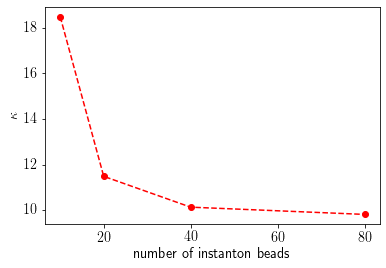

In [34]:
kappadat = np.array([
    [10  ,  18.486247675370873],
    [20  ,  11.481103709870357],
    [40  ,  10.127813329699068],
    [80  ,   9.809437521247709]])

plt.plot(kappadat[:,0],kappadat[:,1],'ro--')
plt.xlabel(r'number of instanton beads')
plt.ylabel(r'$\kappa$')
plt.show()

<h2><strong><span style="font-size:24px;">References </span></strong></h2>

[1] Jeremy O. Richardson. Ring-polymer instanton theory. Int. Rev. Phys. Chem.,
37:171, <strong>2018</strong>.
<br>[2] Jose C Corchado, Jose L Bravo, and Joaquin Espinosa-Garcia. The hydrogen
abstraction reaction H + CH_4 . I. New analytical potential energy surface based
on fitting to ab initio calculations. J. Chem. Phys., 130(18): 184314, <strong>2009</strong>.